# Classical Random Walk on a Quantum Computer
### In our setting we consider a typical classical 1-D random walk setting, consisting of:
* n = starting position. We restrict to positive integer values.
* p = probability of walking up / down the integer line.
* steps = integer time steps that we allow the system evolve.
### Can we use a quantum computer to evolve a lot of these experiments simultaneously?
1) Encode the starting position in a quantum circuit
2) Create a coin-flip circuit
3) Create add and sub gates 
4) Apply the gates to the position circuit, conditioned to the coin-flip,  for steps number of times 
5) Put the circuit together, run experiments and show the final distribution
6) Improving the circuit with QFT

### 1) Encode the starting position in a quantum circuit
Convert the number to binary and use "binary encoding" to set up an initial state of a quantum register. This step is easily accomplished by starting in all-'0's state and appying X gates to the '1' bits. We will use the little endian convention (least significant digit stored in the first qubit). 

Note that for circuit of this size the number of time steps cannot be greater than n itself, as the quantum register would not be large enough. In order to mitigate this behavior one can create a larger register, for example using the double flag already provided.

In [1]:
from qiskit import QuantumRegister, QuantumCircuit

def encode_basis(n, double=False):
    num_qubits = n.bit_length()
    
    if double:
        num_qubits *= 2
        num_qubits -= 1
        
    qnum = QuantumRegister(num_qubits, 'q_num')
    
    circuit = QuantumCircuit(qnum)
    
    for i in range(num_qubits):
        if (n >> i) & 1:
            circuit.x(qnum[i])
    return circuit

In [2]:
n = 11
print(f'The number {n} in binary is: {bin(n)[2:]}')
print(f'The quantum circuit for {bin(n)[2:]} is (read bottom to top):')
print(encode_basis(11))

The number 11 in binary is: 1011
The quantum circuit for 1011 is (read bottom to top):
         ┌───┐
q_num_0: ┤ X ├
         ├───┤
q_num_1: ┤ X ├
         └───┘
q_num_2: ─────
         ┌───┐
q_num_3: ┤ X ├
         └───┘


### 2) Create a coin-flip circuit

In order to decide whether to move up or down we need to flip a coin, at each time step.
A quantum coin is easily implemented by using an 'H' gate, which puts a qubit in a |0⟩ and |1⟩ in superposition, and can be used to make a decision, add or subtract.

You can bias the coin by setting the bias parameter (set to equal probability by default). A value closer to 0 increases the probability of |0⟩, while a value closer to 1 favors the |1⟩ state. 

**RQ: Why is it more appropriate to use ry instead of rx?**

In [3]:
from numpy import pi

def qcoin(bias=0.5):
    if bias < 0 or bias > 1:
        raise ValueError("Bias should be between 0 and 1")
    
    qcoin_reg = QuantumRegister(1)
    qc = QuantumCircuit(qcoin_reg)
    qc.h(0)   
    theta = pi * (1 - 2 * bias)   
    qc.ry(theta, 0)
    return qc

In [4]:
print(qcoin())

    ┌───┐┌───────┐
q0: ┤ H ├┤ Ry(0) ├
    └───┘└───────┘


### 3) Create add and sub gates 
### Add gate 
An add gate increments by one the number encoded. In practice we need to sum '1' to least significant qubit. This is not a problem if the least significant qubit is currently '0'. However if it is already a '1' we need to carry on the operation onto the second-to-least significant qubit, and set the least significant qubit back to '0'. If otherwise also the second-to-least significant qubit is set to '1'... the carry goes on. The worst scenario can escalate to the entire register. 

The add gate is thus implemented with multi-controlled-X gates, arranged in a ladder, so that the first mcx controls all the digits, the second controls n-1 digits and so on, making sure that only the proper qubits are flipped.

If a value more than '1' needs to be added, one can use the "value" parameter. The effect of the inner for loop is to add 1 to the quantum register. Since the outer loop runs "value" times, the quantum register is incremented by "value".

Note that these type of gates are often very difficult to implement in real-hardware, as multi-qubit connections can be difficult to implement with high fidelity.

In our implementation the last qubit (on the bottom) should not be part of the gate, but it is needed to control the quantum coin.

In [5]:
def add_gate(n, value=1):
    add = QuantumCircuit(n, name='add')
    for _ in range(value):
        for i in reversed(range(1,n-1)):
            add.mcx([n-1,*[j for j in range(i)]],i)
        add.cx(n-1,0) 
    add.x(n-1)
    return add.to_instruction()

A self-contained example clarifies the use of the function. 

We will encode '5' and use add_gate to sum '2' obtaining 5+2=7 in the final measurement. 

Begin encoding '5' as '101'. In the unrolled circuit this is represented as an X gate (aka U3(π,0,π)) on q_num_0 and q_num_3 using a double sized register. 

We use a fake quantum coin since our add_gate is prepared for the random walk, which is meant to activate the add_gate, this is represented by the X gate on q_num_3. 

Then, since value = '2' the add_gate applies two times the ladder of mcx. 

Final measurement is performed only on the encoded qubits, using a statevector simulator to obtain the ideal result, '111' = 7.

In [6]:
from qiskit import Aer, execute, ClassicalRegister

NUM = 5                                    # encode '5' in register
ADD_VALUE = 2                              # add '2' to register

qc = encode_basis(NUM,double=True)         # use 'double' to allow space for quantum coin

QCNUM_SIZE = qc.num_qubits//2+1            # actual size of encoded info in circuit 

qc.x(QCNUM_SIZE)                           # set fake quantum coin to '1' = add

qc.append(add_gate(QCNUM_SIZE+1,ADD_VALUE),range(QCNUM_SIZE+1))  

qc.add_register(ClassicalRegister(QCNUM_SIZE))   # measure only qubits that encode the number
qc.measure(range(QCNUM_SIZE),range(QCNUM_SIZE))                           
print(qc.decompose())

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
result.get_counts()

         ┌───────────┐          ┌───┐             ┌───┐        ┌─┐
q_num_0: ┤ U3(π,0,π) ├──■────■──┤ X ├──■────■─────┤ X ├────────┤M├
         └───────────┘  │  ┌─┴─┐└─┬─┘  │  ┌─┴─┐   └─┬─┘┌─┐     └╥┘
q_num_1: ───────────────■──┤ X ├──┼────■──┤ X ├─────┼──┤M├──────╫─
         ┌───────────┐┌─┴─┐└─┬─┘  │  ┌─┴─┐└─┬─┘┌─┐  │  └╥┘      ║ 
q_num_2: ┤ U3(π,0,π) ├┤ X ├──┼────┼──┤ X ├──┼──┤M├──┼───╫───────╫─
         ├───────────┤└─┬─┘  │    │  └─┬─┘  │  └╥┘  │   ║ ┌───┐ ║ 
q_num_3: ┤ U3(π,0,π) ├──■────■────■────■────■───╫───■───╫─┤ X ├─╫─
         └───────────┘                          ║       ║ └───┘ ║ 
q_num_4: ───────────────────────────────────────╫───────╫───────╫─
                                                ║       ║       ║ 
   c0: 3/═══════════════════════════════════════╩═══════╩═══════╩═
                                                2       1       0 


{'111': 1}

### Sub gate

How to make a sub gate efficiently? We can exploit a feature exclusive to quantum computing, reversibility!

A sub_gate is then just an add_gate in reverse:

In [7]:
def sub_gate(n, value=1):
    sub = QuantumCircuit(n, name='sub')
    for _ in range(value):
        sub.cx(n-1,0)
        for i in range(1,n-1):
            sub.mcx([n-1,*[j for j in range(i)]],i)
    sub.x(n-1)
    return sub.to_instruction()

We can run the same example as before with the sub gate, to show that if we start from '5' and we subtract '2' we obtain 5 - 2 = 3 (aka '011')

In [8]:
NUM = 5                                    # encode '5' in register
SUB_VALUE = 2                              # sub '2' to register

qc = encode_basis(NUM,double=True)         # use 'double' to allow space for quantum coin

QCNUM_SIZE = qc.num_qubits//2+1            # actual size of encoded info in circuit 

qc.x(QCNUM_SIZE)                           # set fake quantum coin to '1' = sub

qc.append(sub_gate(QCNUM_SIZE+1,SUB_VALUE),range(QCNUM_SIZE+1))  

qc.add_register(ClassicalRegister(QCNUM_SIZE))   # measure only qubits that encode the number
qc.measure(range(QCNUM_SIZE),range(QCNUM_SIZE))                           
print(qc.decompose())

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()
result.get_counts()

         ┌───────────┐┌───┐          ┌───┐               ┌─┐      
q_num_0: ┤ U3(π,0,π) ├┤ X ├──■────■──┤ X ├──■────■───────┤M├──────
         └───────────┘└─┬─┘┌─┴─┐  │  └─┬─┘┌─┴─┐  │       └╥┘┌─┐   
q_num_1: ───────────────┼──┤ X ├──■────┼──┤ X ├──■────────╫─┤M├───
         ┌───────────┐  │  └─┬─┘┌─┴─┐  │  └─┬─┘┌─┴─┐      ║ └╥┘┌─┐
q_num_2: ┤ U3(π,0,π) ├──┼────┼──┤ X ├──┼────┼──┤ X ├──────╫──╫─┤M├
         ├───────────┤  │    │  └─┬─┘  │    │  └─┬─┘┌───┐ ║  ║ └╥┘
q_num_3: ┤ U3(π,0,π) ├──■────■────■────■────■────■──┤ X ├─╫──╫──╫─
         └───────────┘                              └───┘ ║  ║  ║ 
q_num_4: ─────────────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
   c1: 3/═════════════════════════════════════════════════╩══╩══╩═
                                                          0  1  2 


{'011': 1}

### 4) Apply the gates to the position circuit, conditioned to the coin-flip, for steps number of times 
We now have all the ingredients necessary to compute a classical random walk on a quantum computer.
We need to decide for each time step whether to add or subtract a value from the current position. How to implement conditioned coin flip at each time step? 

We prepared the both the add_gate and the sub_gate to be controlled by an extra qubit, which is going to be a quantum coin qubit. This means that we can create a quantum coin for each time step, add it to our quantum register and use it to decide how to move. 

**RQ: Is there a way of using only one qubit to perform all the coin flips? If one could reset the state of the qubit (i.e. using mid-circuit measurements) one could re-initialize the quantum coin as if it were a brand new qubit**

To concatenate the two circuits we create an helper function, cat_qc. This function takes a variable number of QuantumCircuit objects, combines their quantum and classical registers to initialize a new circuit, and then iteratively composes the operations of each input circuit into the new concatenated circuit. This effectively joins the operations of multiple circuits together while ensuring proper handling of qubit and classical bit indices.

We also provide a helper function to decode the binary results. 

In [9]:
def decode_result(result):
    return {int(k, 2):result[k] for k in result.keys()}

def cat_qc(*all_qc):
    out_qc_qregs =[]
    out_qc_cregs =[]    
    for qc in all_qc:
        out_qc_qregs += qc.qregs
        out_qc_cregs += qc.cregs
    out_qc = QuantumCircuit(*out_qc_qregs, *out_qc_cregs)

    qubits_offset = 0
    clbits_offset = 0

    for qc in all_qc:
        out_qc.compose(qc,
                       [i for i in range(qubits_offset,qubits_offset+qc.num_qubits)],
                       [i for i in range(clbits_offset,clbits_offset+qc.num_clbits)],
                       inplace=True)
        qubits_offset += qc.num_qubits    
        clbits_offset += qc.num_clbits    

    return out_qc    

We can show in this example how a classical random walk circuit would look like

In [10]:
n = 4                                                       
qnum = encode_basis(n,double=False)

steps = 3
num_coins = steps

qc = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])         
add = add_gate(qnum.num_qubits+1)
sub = sub_gate(qnum.num_qubits+1)

print(f"Starting number in dec: {n}")
print(f"Starting number in bin: {bin(n)[2:]}")
print(f"Num steps: {steps}")
print(f"Num qubits: {qc.num_qubits}")

for i in range(steps):
    qc.append(add,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])
    qc.append(sub,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])  
print(qc.decompose())

Starting number in dec: 4
Starting number in bin: 100
Num steps: 3
Num qubits: 6
                                            ┌───┐     ┌───┐                    »
q_num_0: ───────────────────────────■────■──┤ X ├─────┤ X ├──■────■────■────■──»
                                    │  ┌─┴─┐└─┬─┘     └─┬─┘┌─┴─┐  │    │  ┌─┴─┐»
q_num_1: ───────────────────────────■──┤ X ├──┼─────────┼──┤ X ├──■────■──┤ X ├»
         ┌───────────┐            ┌─┴─┐└─┬─┘  │         │  └─┬─┘┌─┴─┐┌─┴─┐└─┬─┘»
q_num_2: ┤ U3(π,0,π) ├────────────┤ X ├──┼────┼─────────┼────┼──┤ X ├┤ X ├──┼──»
         └┬─────────┬┘┌──────────┐└─┬─┘  │    │         │    │  └─┬─┘└─┬─┘  │  »
    q11: ─┤ U2(0,π) ├─┤ R(0,π/2) ├──┼────┼────┼─────────┼────┼────┼────┼────┼──»
          ├─────────┤ ├──────────┤  │    │    │         │    │    │    │    │  »
    q12: ─┤ U2(0,π) ├─┤ R(0,π/2) ├──┼────┼────┼─────────┼────┼────┼────■────■──»
          ├─────────┤ ├──────────┤  │    │    │  ┌───┐  │    │    │  ┌───┐     »
    q13: ─┤ U2(0,π) ├─┤ R(0,

### 5) Put the circuit together, run experiments and show the final distribution
In a final example we showcase how to compute many random walks simultaneously using the qasm_simulator to obtain a final position distribution

Starting number in dec: 128
Num steps: 14
Num qubits: 22


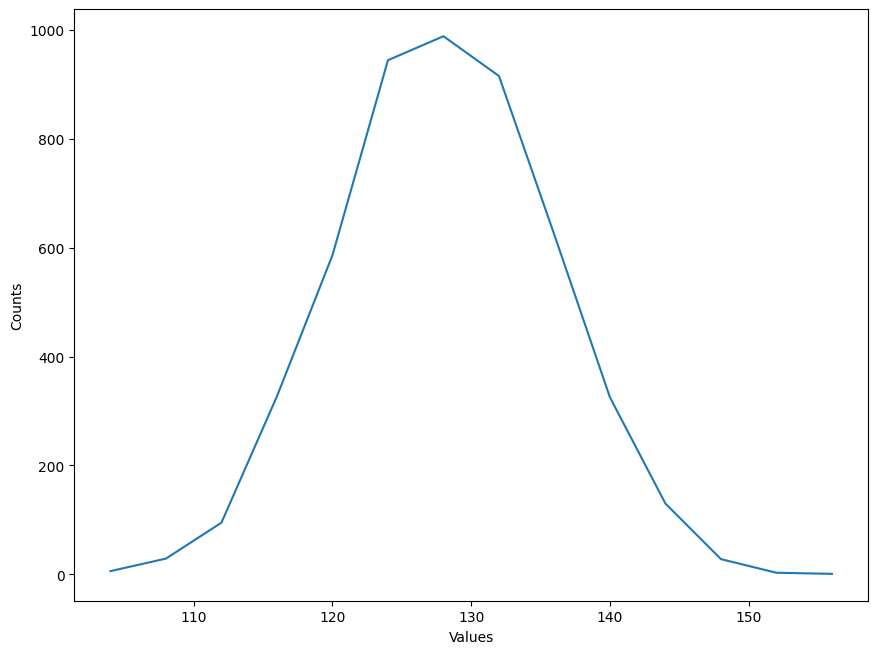

In [11]:
import matplotlib.pyplot as plt

n = 2**7                                                        
qnum = encode_basis(n,double=False)

steps = 14
num_coins = steps

qc = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])         

add = add_gate(qnum.num_qubits+1,value=2)
sub = sub_gate(qnum.num_qubits+1,value=2)

print(f"Starting number in dec: {n}")
print(f"Num steps: {steps}")
print(f"Num qubits: {qc.num_qubits}")

for i in range(steps):
    qc.append(add,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])
    qc.append(sub,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])   

qc.add_register(ClassicalRegister(qnum.num_qubits+1))
qc.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=5000)
result = job.result().get_counts(qc)

plt.ion()
fig, ax = plt.subplots(figsize = (10.24,7.68))
result = decode_result(result)

x = sorted(result.keys())
y = [result[k] for k in x]
ax.plot(x, y)

plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()
plt.ioff()

We can generate biased distributions and compare them to the unbiased one

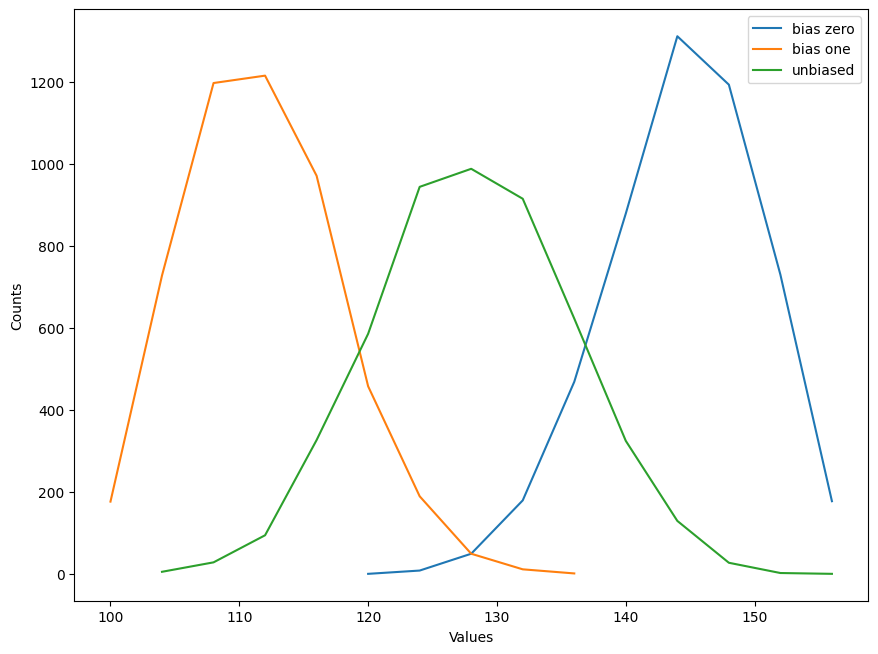

In [12]:
import matplotlib.pyplot as plt

n = 2**7                                                        
qnum = encode_basis(n,double=False)

steps = 14
num_coins = steps

qc_bias_zero = cat_qc(qnum,*[qcoin(0.4,) for _ in range(num_coins)])         
qc_bias_one = cat_qc(qnum,*[qcoin(0.6) for _ in range(num_coins)])         

add = add_gate(qnum.num_qubits+1,value=2)
sub = sub_gate(qnum.num_qubits+1,value=2)

for i in range(steps):
    qc_bias_zero.append(add,[*(range(qnum.num_qubits)), qc_bias_zero.num_qubits-1-i])
    qc_bias_zero.append(sub,[*(range(qnum.num_qubits)), qc_bias_zero.num_qubits-1-i])   

qc_bias_zero.add_register(ClassicalRegister(qnum.num_qubits+1))
qc_bias_zero.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])

backend = Aer.get_backend('qasm_simulator')
job_bias_zero = execute(qc_bias_zero, backend, shots=5000)
result_bias_zero = job_bias_zero.result().get_counts(qc_bias_zero)
result_bias_zero = decode_result(result_bias_zero)

for i in range(steps):
    qc_bias_one.append(add,[*(range(qnum.num_qubits)), qc_bias_one.num_qubits-1-i])
    qc_bias_one.append(sub,[*(range(qnum.num_qubits)), qc_bias_one.num_qubits-1-i])   

qc_bias_one.add_register(ClassicalRegister(qnum.num_qubits+1))
qc_bias_one.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])

backend = Aer.get_backend('qasm_simulator')
job_bias_one = execute(qc_bias_one, backend, shots=5000)
result_bias_one = job_bias_one.result().get_counts(qc_bias_one)
result_bias_one = decode_result(result_bias_one)

plt.ion()
fig, ax = plt.subplots(figsize = (10.24,7.68))

x0 = sorted(result_bias_zero.keys())
y0 = [result_bias_zero[k] for k in x0]
ax.plot(x0, y0, label='bias zero')

x1 = sorted(result_bias_one.keys())
y1 = [result_bias_one[k] for k in x1]
ax.plot(x1, y1, label='bias one')
ax.plot(x, y,label='unbiased')
plt.legend()
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()
plt.ioff()

### 6) Improving the circuit with QFT

As mentioned before, the add and sub gates are not easily implemented in all machines. However we can make use of the [Quantum Fourier Transform](https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform) to move our position number into the phases of the qubits, moving from "basis encoding" to "phase encoding" with a QFT transformation.

We can then add and subtract in the phase space (with different add and sub gates suitable for this encoding) and finally decode our number back to basis encoding with an inverse QFT.

Let's introduce the new add and sub gates. For this example we will make a simple increment / decrement gate. 

In [13]:
def add_qft_gate(n):
    add = QuantumCircuit(n, name='add_qft')
    for q in range(n-1):
        add.cp(pi/(2**q),n-1,q)
    add.x(n-1)
    return add.to_instruction()

def sub_qft_gate(n):
    add = QuantumCircuit(n, name='sub_qft')
    for q in range(n-1):
        add.cp(-pi/(2**q),n-1,q)
    add.x(n-1)
    return add.to_instruction()

We can compare the cost of implementing the two variations (MCX and QFT) of the same random walk. We observe that the QFT allows us to create much shorter circuits, with less complicated gates. 

In [14]:
from qiskit.circuit.library import QFT

n = 2**7
qnum = encode_basis(n,double=False)

add = add_gate(qnum.num_qubits+1)
sub = sub_gate(qnum.num_qubits+1)
add_qft = add_qft_gate(qnum.num_qubits+1)
sub_qft = sub_qft_gate(qnum.num_qubits+1)

steps = 14
num_coins = steps

qc = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])         
qc_qft = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])

qc_qft.append(QFT(qnum.num_qubits, do_swaps=False, inverse=False), range(qnum.num_qubits))
for i in range(steps):
    qc_qft.append(add_qft,[*(range(qnum.num_qubits)), qc_qft.num_qubits-1-i])
    qc_qft.append(sub_qft,[*(range(qnum.num_qubits)), qc_qft.num_qubits-1-i])   
qc_qft.append(QFT(qnum.num_qubits, do_swaps=False, inverse=True), range(qnum.num_qubits))
# print(qc_qft.decompose())

for i in range(steps):
    qc.append(add,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])
    qc.append(sub,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])  

print(f'Multi-control-X circuit depth: {qc.decompose().decompose().depth()}')
print(f'QFT circuit depth: {qc_qft.decompose().decompose().depth()}')
print()
print(f'Multi-control-X instructions: {dict(qc.decompose().decompose().count_ops())}')
print(f'QFT circuit instructions: {dict(qc_qft.decompose().decompose().count_ops())}')


Multi-control-X circuit depth: 1457
QFT circuit depth: 570

Multi-control-X instructions: {'cx': 588, 'h': 448, 'p': 420, 'mcu1': 112, 't': 112, 'tdg': 84, 'u3': 56, 'cu1': 56, 'rcccx': 28, 'rcccx_dg': 28, 'c3sx': 28, 'u': 1}
QFT circuit instructions: {'p': 672, 'cx': 448, 'cp': 56, 'u3': 56, 'h': 16, 'u': 1}


The two variations should have the same outcome. Let's see if this is the case:

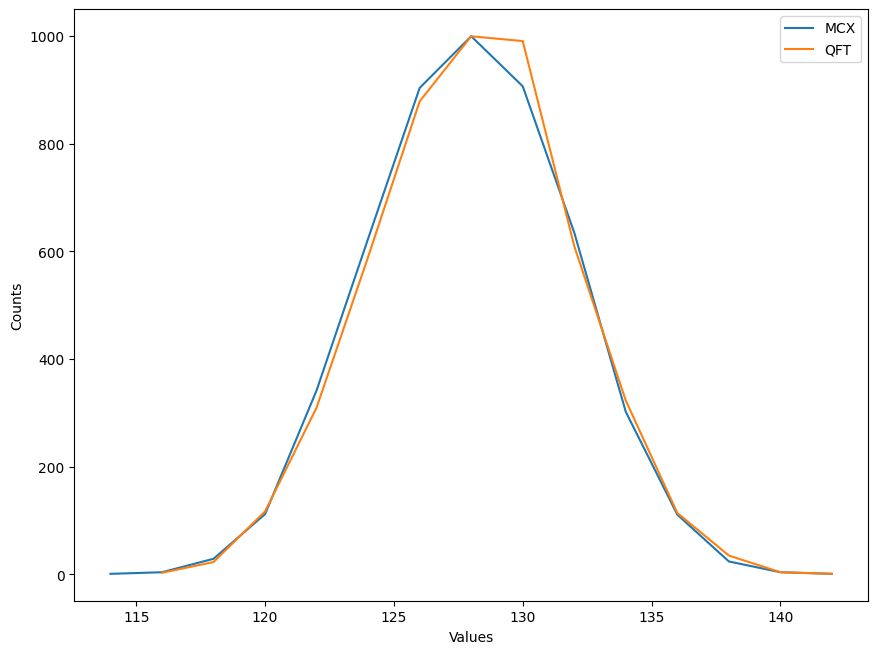

In [15]:
qc.add_register(ClassicalRegister(qnum.num_qubits+1))
qc.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=5000)
result = job.result().get_counts(qc)
result = decode_result(result)

qc_qft.add_register(ClassicalRegister(qnum.num_qubits+1))
qc_qft.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])
backend = Aer.get_backend('qasm_simulator')
job_qft = execute(qc_qft, backend, shots=5000)
result_qft = job_qft.result().get_counts(qc_qft)
result_qft = decode_result(result_qft)

plt.ion()
fig, ax = plt.subplots(figsize = (10.24,7.68))

x = sorted(result.keys())
y = [result[k] for k in x]
ax.plot(x, y, label='MCX')

x_qft = sorted(result_qft.keys())
y_qft = [result_qft[k] for k in x_qft]
ax.plot(x_qft, y_qft, label='QFT')

plt.legend()
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()
plt.ioff()

Here is the same code with 40 steps. You can observe that thanks to the particular structure of the QFT we are able to simulate many more qubits that are available through MCX. If you decomment the comments you will obtain a memory error 

QFT circuit qubit number: 48
QFT circuit depth: 1532
QFT circuit instructions: {'p': 1920, 'cx': 1280, 'u3': 160, 'cp': 56, 'h': 16, 'u': 1}


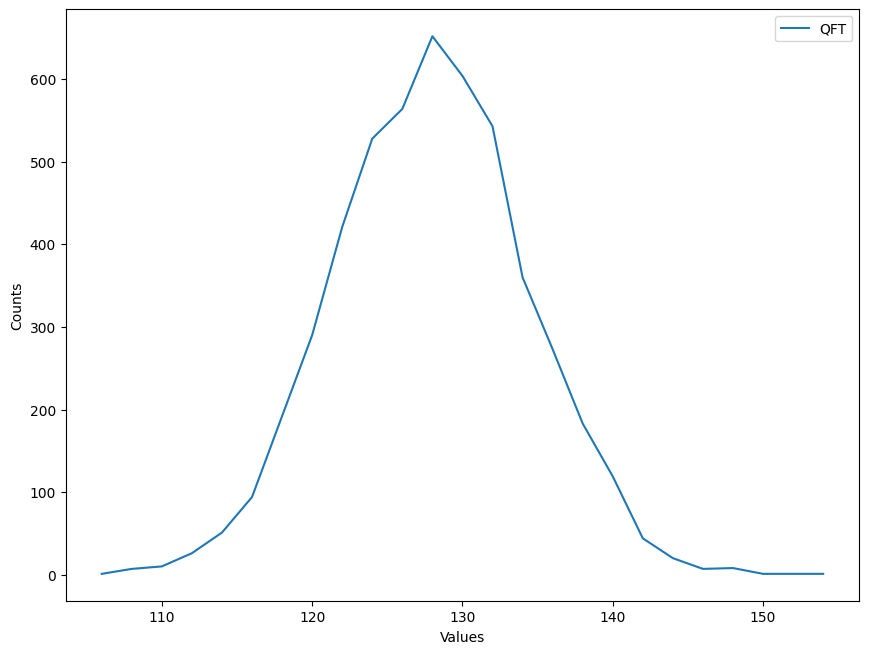

In [16]:
from qiskit.circuit.library import QFT

n = 2**7
qnum = encode_basis(n,double=False)

# add = add_gate(qnum.num_qubits+1)
# sub = sub_gate(qnum.num_qubits+1)
add_qft = add_qft_gate(qnum.num_qubits+1)
sub_qft = sub_qft_gate(qnum.num_qubits+1)

steps = 40
num_coins = steps

# qc = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])         
qc_qft = cat_qc(qnum,*[qcoin() for _ in range(num_coins)])

qc_qft.append(QFT(qnum.num_qubits, do_swaps=False, inverse=False), range(qnum.num_qubits))
for i in range(steps):
    qc_qft.append(add_qft,[*(range(qnum.num_qubits)), qc_qft.num_qubits-1-i])
    qc_qft.append(sub_qft,[*(range(qnum.num_qubits)), qc_qft.num_qubits-1-i])   
qc_qft.append(QFT(qnum.num_qubits, do_swaps=False, inverse=True), range(qnum.num_qubits))

# for i in range(steps):
#     qc.append(add,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])
#     qc.append(sub,[*(range(qnum.num_qubits)), qc.num_qubits-1-i])  

# print(f'Multi-control-X circuit depth: {qc.decompose().decompose().depth()}')
print(f'QFT circuit qubit number: {qc_qft.num_qubits}')
print(f'QFT circuit depth: {qc_qft.decompose().decompose().depth()}')
# print(f'Multi-control-X instructions: {dict(qc.decompose().decompose().count_ops())}')
print(f'QFT circuit instructions: {dict(qc_qft.decompose().decompose().count_ops())}')

# qc.add_register(ClassicalRegister(qnum.num_qubits+1))
# qc.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])
# backend = Aer.get_backend('qasm_simulator')
# job = execute(qc, backend, shots=5000)
# result = job.result().get_counts(qc)
# result = decode_result(result)

qc_qft.add_register(ClassicalRegister(qnum.num_qubits+1))
qc_qft.measure([i for i in range(qnum.num_qubits)],[i for i in range(qnum.num_qubits)])
backend = Aer.get_backend('qasm_simulator')
job_qft = execute(qc_qft, backend, shots=5000)
result_qft = job_qft.result().get_counts(qc_qft)
result_qft = decode_result(result_qft)

plt.ion()
fig, ax = plt.subplots(figsize = (10.24,7.68))

# x = sorted(result.keys())
# y = [result[k] for k in x]
# ax.plot(x, y, label='MCX')

x_qft = sorted(result_qft.keys())
y_qft = [result_qft[k] for k in x_qft]
ax.plot(x_qft, y_qft, label='QFT')

plt.legend()
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()
plt.ioff()